# 4.利用隐变量解释

In [1]:
import sys
sys.path = ["../../.."] + sys.path # 切换到项目目录下

import scvelo as scv
import velovgi

Global seed set to 0
/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## 1. 数据读入

In [2]:
adata = velovgi.tl.read_adata("./data/adata/")

batch_key = "stage"
cluster_key = "celltype"
pseudotime_key = "velocity_pseudotime"
adata

load ./data/adata//adata.h5ad
load ./data/adata//sample_recover.pkl


AnnData object with n_obs × n_vars = 9815 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    layers: 'Ms', 'Mu', 'fit_t', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

## 2. 隐层表示提取

1. 提取隐变量

In [3]:
epochs = 50
model_dir = "model/%s_epoch(max_epochs=%s)"%(epochs, epochs)
# velovgi_model = velovgi.tl.VELOVGI.load(model_dir, adata=adata, use_gpu=True) # 需要根据gpu进行调换
velovgi_model = velovgi.tl.VELOVGI.load(model_dir, adata=adata, use_gpu=False) # 需要根据gpu进行调换
latent_umap_key = "X_latent_umap"
velovgi.tl.get_latent_umap(adata, velovgi_model, latent_umap_key=latent_umap_key, random_seed=1000)

INFO     File model/50_epoch(max_epochs=50)/model.pt already downloaded                                            


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


AnnData object with n_obs × n_vars = 9815 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap', 'velocity_umap', 'X_latent', 'X_latent_umap'
    layers: 'Ms', 'Mu', 'fit_t', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

2. 隐变量的降维速率图

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_latent_umap', embedded velocity vectors (adata.obsm)


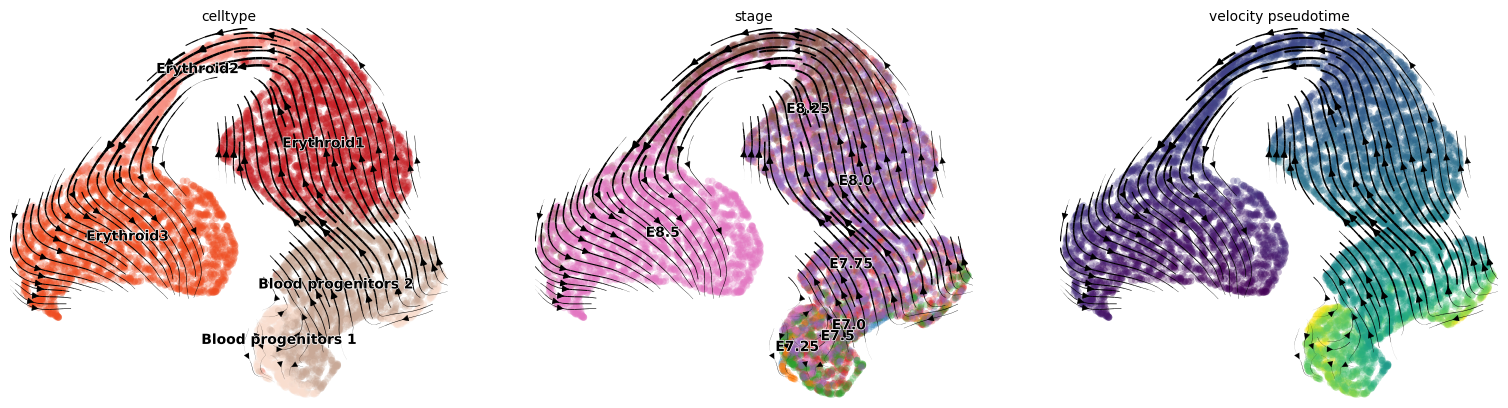

In [4]:
scv.pl.velocity_embedding_stream(adata, color=[cluster_key, batch_key, pseudotime_key], basis=latent_umap_key, colorbar=False)

## 2. 利用网络权重理解

Text(70.72222222222221, 0.5, 'Latent Dimensions')

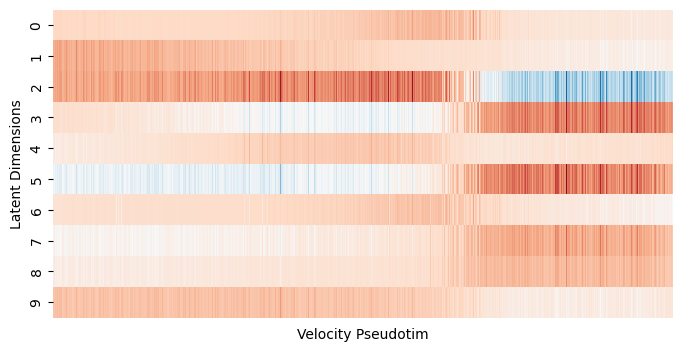

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

figsize = (8, 4)
plt.figure(figsize=figsize)

# 隐变量排序
sorted_index = adata.obs["velocity_pseudotime"].sort_values().index
sorted_adata = adata[sorted_index]
latent_reprentation = sorted_adata.obsm["X_latent"]

# 显示聚类相关的颜色
color_dict = dict(zip(adata.obs[cluster_key].cat.categories, adata.uns["%s_colors"%cluster_key]))
color_list = adata.obs[cluster_key].apply(lambda x: color_dict[x]).to_numpy()

# 绘制隐变量热图
# sns.clustermap(latent_reprentation, row_cluster=False, col_cluster=False, row_colors=color_list, cbar_pos=(1, 0.05, 0.05, 0.3), cmap="RdBu_r")
sns.heatmap(latent_reprentation.T, cmap="RdBu_r", cbar=False) # 不要颜色条
plt.xticks([])
plt.xlabel("Velocity Pseudotim")
plt.ylabel("Latent Dimensions")

2. 编码器的特征提取整体与部分权重可视化

<AxesSubplot: >

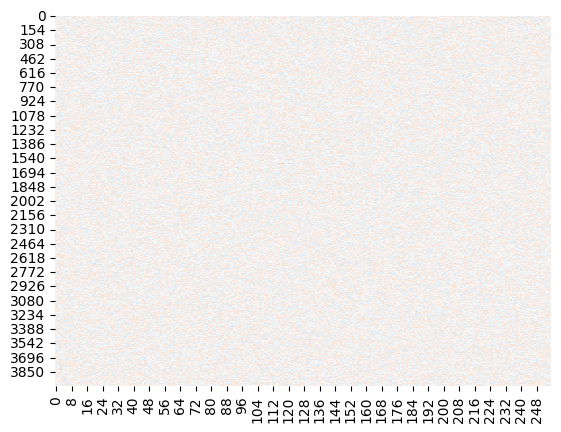

In [6]:
import numpy as np

gcn_weight = velovgi_model.module.z_encoder.encoder.gnn_layers[0][0].lin.weight.detach().cpu().numpy()
sns.heatmap(gcn_weight.T, cmap="RdBu_r", cbar=False)

[1600, 305, 1599, 914, 1373]


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
Hbb-y,-0.076373,0.019082,0.121668,-0.054078,0.021271,0.068227,0.076144,0.033871,0.055267,0.155592,...,0.063421,0.072380,0.034344,-0.092371,-0.016956,0.111036,0.013428,-0.042008,0.098635,0.060338
Hba-x,-0.043412,0.086466,0.077293,0.042278,0.065731,0.081921,0.003456,0.048637,0.021697,0.015909,...,-0.061249,-0.033166,0.033445,0.052257,-0.148768,0.062695,0.012516,-0.104743,0.013528,0.078471
Hbb-bh1,-0.003475,0.071134,0.121876,-0.065881,0.017321,0.001383,0.012271,0.014724,0.018088,-0.100091,...,-0.086144,0.050760,0.035084,-0.049938,0.017246,0.024618,0.111468,0.053278,0.019829,0.021485
Fth1,0.007750,0.001278,0.061039,0.001464,0.003749,-0.025484,-0.038110,0.007921,0.010099,-0.027592,...,-0.000381,-0.032865,0.018227,0.043641,0.042921,-0.032824,0.023660,0.031777,-0.006496,-0.041527
Actb,0.015473,0.003572,-0.020485,0.024259,0.025311,-0.007165,0.030412,-0.032072,0.032306,0.058087,...,0.022570,0.018916,0.006676,-0.009240,-0.004266,0.023805,0.008845,-0.016029,0.010020,0.026524


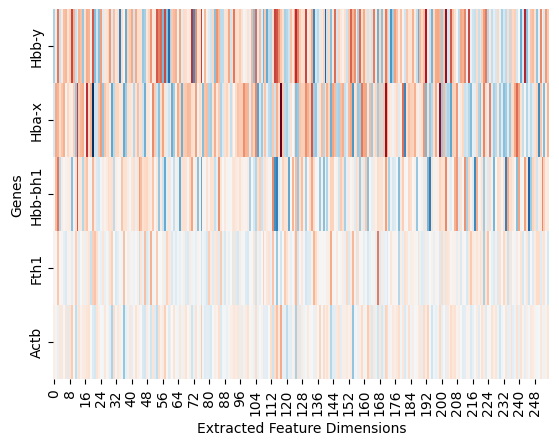

In [7]:
import pandas as pd

n_top = 5
feature_gcn_weight = velovgi_model.module.z_encoder.encoder.gnn_layers[0][0].lin.weight.detach().cpu().numpy()
# index_list = list(np.argsort(feature_gcn_weight.mean(axis=0))[::-1][:n_top])  # 权重最大的前几个
index_list = list(np.argsort(np.abs(feature_gcn_weight).mean(axis=0))[::-1][:n_top])  # 权重绝对值最大的前几个
print(index_list)

gene_index_list = []
for index in index_list:
    if index > 2000:
        index = index-2000
    gene_index_list.append(index)

# 添加基因名
gene_name_list = list(adata.var.iloc[gene_index_list].index)
feature_df = pd.DataFrame(gcn_weight[:, gene_index_list].T)
feature_df.index = gene_name_list

sns.heatmap(feature_df, cmap="RdBu_r", cbar=False)  # 不要颜色条
plt.xlabel("Extracted Feature Dimensions")
plt.ylabel("Genes")

feature_df # 这些基因就可以作为候选的标记基因了

In [14]:
adata.var.iloc[gene_index_list]

,Accession,Chromosome,End,Start,Strand,MURK_gene,Δm,scaled Δm,gene_count_corr,means,dispersions,dispersions_norm,highly_variable
index,,,,,,,,,,,,,
Hbb-y,ENSMUSG00000052187,7,103853216,103851749,-,True,0.000552,0.254151,-0.1235,5.151422,6.606504,0.707107,True
Hba-x,ENSMUSG00000055609,11,32278116,32276400,+,True,0.004803,1.060738,-0.1542,5.678536,5.958082,1.000000,True
Hbb-bh1,ENSMUSG00000052217,7,103843164,103841637,-,True,0.000579,0.427912,-0.1670,6.201933,6.021302,1.000000,True
Fth1,ENSMUSG00000024661,19,9985092,9982703,+,False,NaN,NaN,-0.1004,4.409816,2.080666,1.255709,True
Actb,ENSMUSG00000029580,5,142906754,142903115,-,False,NaN,NaN,0.0635,2.745791,1.665418,1.369361,True


2. 提取与Hbb-y相关性很强的特征

In [20]:
top_n = 2
# gene = "Hbb-y"
gene = "Hba-x"
# gene = "Hbb-bh1"
positive_feature_index_list = list(np.argsort(feature_df.loc[gene])[::-1][:top_n]) # 与Hbb-y相关的特征
negtive_feature_index_list = list(np.argsort(feature_df.loc[gene])[:top_n]) # Hbb-y负相关的特征

Text(50.722222222222214, 0.5, 'Extracted Feature Dimensions')

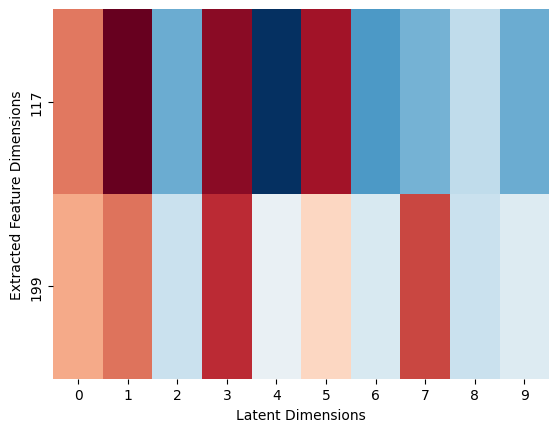

In [21]:
mean_weight = velovgi_model.module.z_encoder.mean_encoder.lin.weight.detach().cpu().numpy()
df = pd.DataFrame(mean_weight[:, positive_feature_index_list].T)
df.index = positive_feature_index_list
sns.heatmap(df, cmap="RdBu_r", cbar=False)
plt.xlabel("Latent Dimensions")
plt.ylabel("Extracted Feature Dimensions")

Text(50.722222222222214, 0.5, 'Extracted Feature Dimensions')

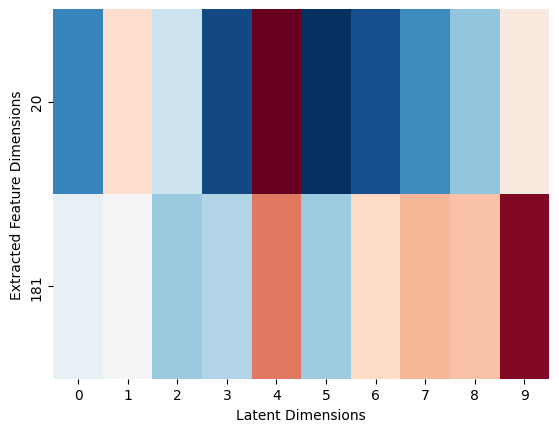

In [22]:
mean_weight = velovgi_model.module.z_encoder.mean_encoder.lin.weight.detach().cpu().numpy()
df = pd.DataFrame(mean_weight[:, negtive_feature_index_list].T)
df.index = negtive_feature_index_list
sns.heatmap(df, cmap="RdBu_r", cbar=False)
plt.xlabel("Latent Dimensions")
plt.ylabel("Extracted Feature Dimensions")